In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def random_matrix(size:int, non_zero_proba: float):
    A = np.zeros((size,size))
    non_zeros = int(A.size*non_zero_proba)
    for i in range(non_zeros):
        x = np.random.randint(size)
        y = np.random.randint(size)
        while A[x,y] != 0:
            x = np.random.randint(size)
            y = np.random.randint(size)
        A[x,y] = np.random.random()
    return A

In [3]:
def divide(A):
    X, Y = A.shape
    return A[:X//2,:Y//2],A[:X//2,Y//2:],A[X//2:,:Y//2],A[X//2:,Y//2:]

In [159]:
class MatrixTree:
    def __init__(self, Matrix:np.ndarray):
        self.matrix = Matrix
        self.zeros = None
        self.A11 = None
        self.A12 = None
        self.A21 = None
        self.A22 = None
        self.u = None
        self.vT = None
    def compute(self):
        if self.matrix is not None:
            return self.matrix
        elif self.zeros is not None:
            return np.zeros(self.zeros)
        elif self.A11 is not None:
            a11, a12, a21, a22 = (i.compute() for i in (self.A11, self.A12, self.A21, self.A22))
            U = np.hstack((a11,a12))
            L = np.hstack((a21,a22))
            return np.vstack((U,L))
        else:
            return self.u @ self.vT
    def paint(self):
        #TO DO
        pass

In [160]:
def get_tolerated(v, tol, a = 0, b = None):
    #print("a: ",a,end="\t")
    #print("b: ",b,end="\t")
    #wyszukiwanie binarne najmniejszego elementu niemniejszego od tolerance
    if b == None:
        b = len(v)-1
    m = (a + b)//2
    if v[b]>tol:
        return v[:b+1]
    #print("m: ",m)
    val = v[m]
    if  a == b:
        if val >= tol:
            return v[:m+1]
        return []
    if val < tol:
        return get_tolerated(v, tol, a, m-1)
    elif m+1<len(v) and v[m+1]<tol:
        return v[:m+1]
    return get_tolerated(v, tol, m, b)
    

In [266]:
def decompose(tree: MatrixTree, u: np.ndarray, d: np.ndarray, vT: np.ndarray) -> None:
    if len(d)==0:
        print("zero rank matrix")
        tree.zeros=tree.matrix.shape
        tree.matrix = None
        return
    tree.matrix = None
    d = np.diag(d) if len(d)>1 else np.array([d])
    #print("d:\t",d)
    #print("u:\t",u)
    tree.u = u @ d
    tree.vT = vT

In [267]:
def compress(tree: MatrixTree, sigma: float, b: int, max_depth: int):
    #print(tree.matrix.shape)
    #print(max_depth)
    if not np.any(tree.matrix > 0.0):
        #print(tree.matrix.shape)
        tree.zeros = tree.matrix.shape
        tree.matrix = None
        return
    if max_depth == 0:
        u, s, vT = np.linalg.svd(tree.matrix)
        s = get_tolerated(s, sigma)[:b]
        new_rank  = len(s)
        u  =  u[:, :new_rank]
        vT = vT[:new_rank, :]
        decompose(tree, u, s, vT)
        return
    u, s, vT = np.linalg.svd(tree.matrix)
    s = get_tolerated(s, sigma)
    new_rank = len(s)
    if new_rank <= b:
        u  =  u[:, :new_rank]
        vT = vT[:new_rank, :]
        decompose(tree, u, s, vT)
        return
    else:
        A11, A12, A21, A22 = divide(tree.matrix)
        tree.matrix = None
        tree.A11 = MatrixTree(A11)
        tree.A12 = MatrixTree(A12)
        tree.A21 = MatrixTree(A21)
        tree.A22 = MatrixTree(A22)
        compress(tree.A11, sigma, b, max_depth-1)
        compress(tree.A12, sigma, b, max_depth-1)
        compress(tree.A21, sigma, b, max_depth-1)
        compress(tree.A22, sigma, b, max_depth-1)

In [303]:
A = random_matrix(64,0.2)

In [304]:
t = MatrixTree(A)

In [305]:
zeros = t.matrix.shape

In [306]:
np.zeros(zeros).shape

(64, 64)

In [307]:
compress(t,0.01,4,4)

zero rank matrix


In [308]:
t.matrix

In [309]:
t.A11.A11.A11.A11.vT

array([[-0.34124709,  0.        ,  0.        , -0.93997363],
       [ 0.93997363,  0.        ,  0.        , -0.34124709]])

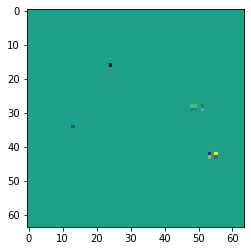

In [310]:
plt.imshow(t.compute()-A)

In [171]:
np.linalg.norm(t.compute()-A)

0.02067237079060069